In [1]:
import openreview
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
import numpy as np
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/akgoldbe/opt/anaconda3/envs/analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = openreview.api.OpenReviewClient(
    baseurl='https://api2.openreview.net',
)
# get all submissions to NeurIPS 2024
VENUE_ID = 'ICLR.cc/2025/Conference'
venue_group = client.get_group(f'{VENUE_ID}')
submission_name = venue_group.content['submission_name']['value']
submissions = client.get_all_notes(invitation=f'{VENUE_ID}/-/{submission_name}', details='directReplies')

Getting V2 Notes: 100%|█████████▉| 11660/11672 [00:30<00:00, 381.68it/s]


In [3]:
len(submissions)

11672

In [4]:
all_reviews = []
for paper in submissions:
    id = paper.id
    title = paper.content['title']['value']
    primary_area = paper.content['primary_area']['value']
    keywords = paper.content['keywords']['value']
    reviews = []
    decision = None 
    for reply in paper.details['directReplies']:
        if any('Official_Review' in s for s in reply['invitations']):
            rating = reply['content']['rating']['value']
            soundness = reply['content']['soundness']['value']
            presentation = reply['content']['presentation']['value']
            contribution = reply['content']['contribution']['value']
            confidence = reply['content']['confidence']['value']
            reviewer_id = reply['signatures'][0].split('/')[-1]
            review_number = reply['number']
            reviews.append({
                'paper_id': id,
                'title': title,
                'primary_area': primary_area,
                'keywords': keywords,
                'reviewer_id': reviewer_id,
                'rating': rating,
                'soundness': soundness,
                'presentation': presentation,
                'contribution': contribution,
                'confidence': confidence,
                'review_number': review_number
            })
        if any('Decision' in s for s in reply['invitations']):
            if decision is None:
                decision = reply['content']['decision']['value']
    if any('Withdrawn' in s for s in paper.invitations):
        decision = 'Withdrawn'
    for review in reviews:
        review['decision'] = decision
    all_reviews.extend(reviews)

In [5]:
df = pd.DataFrame(all_reviews)

In [6]:
df.head()

,paper_id,title,primary_area,keywords,reviewer_id,rating,soundness,presentation,contribution,confidence,review_number,decision
0,zzR1Uskhj0,High Probability Bounds for Cross-Learning Con...,learning theory,"[contextual bandits, cross-learning, high-prob...",Reviewer_8LjP,6,3,3,3,4,1,Reject
1,zzR1Uskhj0,High Probability Bounds for Cross-Learning Con...,learning theory,"[contextual bandits, cross-learning, high-prob...",Reviewer_Sstz,6,4,3,3,4,2,Reject
2,zzR1Uskhj0,High Probability Bounds for Cross-Learning Con...,learning theory,"[contextual bandits, cross-learning, high-prob...",Reviewer_uDyZ,8,4,3,3,3,3,Reject
3,zzR1Uskhj0,High Probability Bounds for Cross-Learning Con...,learning theory,"[contextual bandits, cross-learning, high-prob...",Reviewer_NZtQ,5,3,3,3,3,4,Reject
4,zzR1Uskhj0,High Probability Bounds for Cross-Learning Con...,learning theory,"[contextual bandits, cross-learning, high-prob...",Reviewer_NaxM,5,2,1,2,3,5,Reject


In [31]:
df.groupby('paper_id').decision.max().value_counts()

decision
Reject                4939
Accept (Poster)       3111
Withdrawn             2870
Accept (Spotlight)     379
Accept (Oral)          213
Name: count, dtype: int64

In [ ]:
df['rating'].isna().sum()

In [32]:
# save as csv
df.to_csv('iclr2025_reviews.csv')

### Generate Intervals (Min + Max Score) ###

In [37]:
df.groupby('paper_id').max().value_counts('decision')

decision
Reject                4939
Accept (Poster)       3111
Withdrawn             2870
Accept (Spotlight)     379
Accept (Oral)          213
Name: count, dtype: int64

In [38]:
ratings = df.groupby('paper_id').agg({'rating': ['max', 'mean', 'min', 'count'], 'decision': 'max'}).reset_index()
ratings.columns = ['paper_id', 'rating_max', 'rating_mean', 'rating_min', 'num_reviews', 'decision']
# rename Accept (poster) to Poster and Accept (oral) or Accept (spotlight) to Spotlight/Oral
ratings['decision'] = ratings['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})
ratings['decision'].value_counts()

decision
Reject                4939
Accept (Poster)       3111
Withdrawn             2870
Accept (Spotlight)     379
Accept (Oral)          213
Name: count, dtype: int64

In [39]:
# subsample ratings by 25% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)


### Generate Intervals (Leave One Out Intervals)

In [ ]:
ratings = df.groupby('paper_id').agg({'rating': list, 'decision': 'max'}).reset_index()

In [ ]:
def get_interval(lst):
    means = []
    for i in range(len(lst)):
        temp_lst = lst[:i] + lst[i+1:]
        mean = 1. * sum(temp_lst) / len(temp_lst)
        means.append(mean)
    return min(means), max(means)

In [ ]:
intervals = ratings['rating'].apply(get_interval)

In [ ]:
ratings['rating_min'] = intervals.apply(lambda x: x[0])
ratings['rating_max'] = intervals.apply(lambda x: x[1])
ratings['rating_mean'] = ratings['rating'].apply(lambda x: sum(x) / len(x))

In [ ]:
ratings

,paper_id,rating,decision,lower,upper,mean,rating_min,rating_max,rating_mean
0,00uVk06eVK,"[7, 7, 5]",Poster,6.000000,7.000000,6.333333,6.000000,7.000000,6.333333
1,01XV5Za56k,"[7, 7, 6, 5]",Poster,6.000000,6.666667,6.250000,6.000000,6.666667,6.250000
2,01qa1ZJs65,"[5, 4, 5, 7]",Poster,4.666667,5.666667,5.250000,4.666667,5.666667,5.250000
3,01s5ODIHKd,"[6, 6, 4, 6]",Poster,5.333333,6.000000,5.500000,5.333333,6.000000,5.500000
4,02CIZ8qeDc,"[5, 6, 7]",Poster,5.500000,6.500000,6.000000,5.500000,6.500000,6.000000
...,...,...,...,...,...,...,...,...,...
4030,zv4UISZzp5,"[7, 4, 4]",Poster,4.000000,5.500000,5.000000,4.000000,5.500000,5.000000
4031,zv9gYC3xgF,"[6, 6, 6, 6]",Poster,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
4032,zw2K6LfFI9,"[6, 6, 7, 6]",Poster,6.000000,6.333333,6.250000,6.000000,6.333333,6.250000
4033,zxSWIdyW3A,"[5, 5, 6, 6]",Poster,5.333333,5.666667,5.500000,5.333333,5.666667,5.500000


In [ ]:
ratings['decision'] = ratings['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})

In [ ]:
# subsample ratings by 25% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)

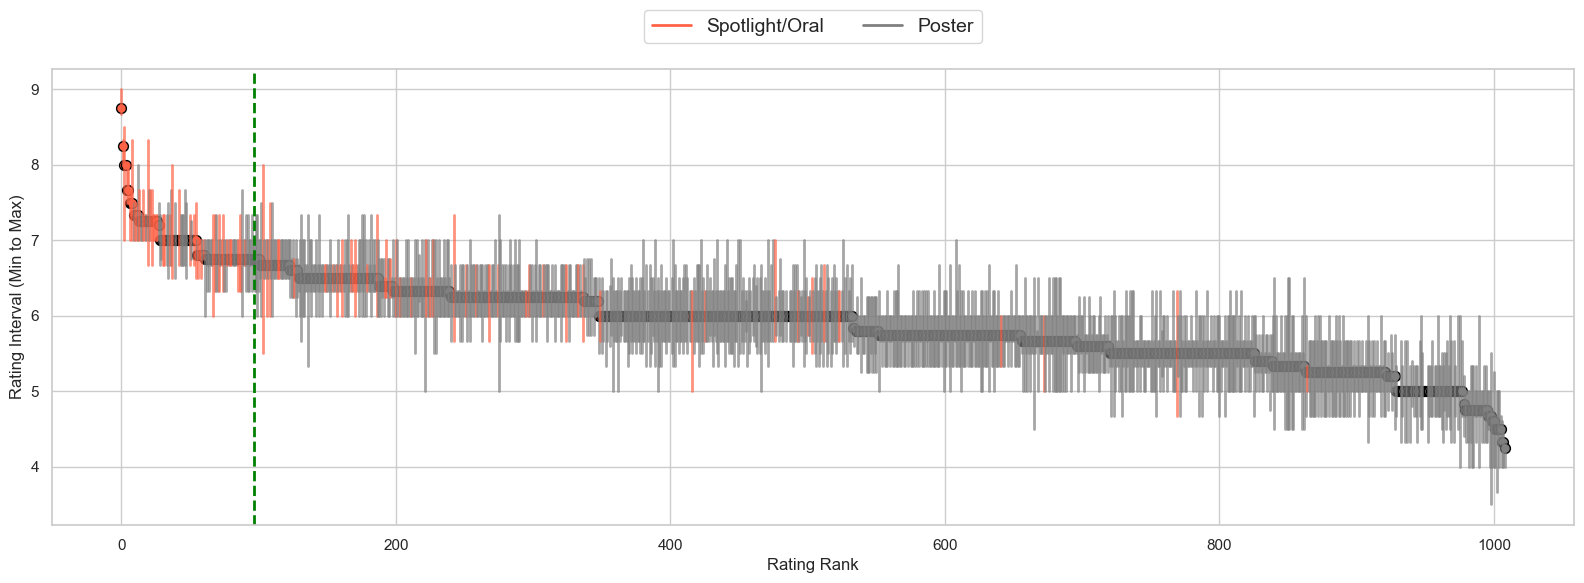

In [ ]:
# order ratings by mean
ratings_sample = ratings_sample.sort_values('rating_mean', ascending=False).reset_index(drop=True)

# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Spotlight/Oral': '#FF6347',  # Tomato
    'Poster': '#808080',          # Gray
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], [row['rating_min'], row['rating_max']], color=color, alpha=0.7, lw=2)
    ax.scatter(idx, row['rating_mean'], color=color, edgecolor='black', s=50, label=row['decision'] if row['decision'] not in ax.get_legend_handles_labels()[1] else "")

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Spotlight/Oral'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Poster/Spotlight Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()

## Generate Intervals from Bayesian Gaussian Model

In [41]:
ratings = df.groupby('paper_id').agg({'rating': list, 'decision': 'max'}).reset_index()

In [42]:
ratings

,paper_id,rating,decision
0,00SnKBGTsz,"[8, 6, 8, 8]",Accept (Spotlight)
1,00ezkB2iZf,"[5, 3, 6, 3]",Reject
2,01wMplF8TL,"[5, 5, 3, 5]",Reject
3,029hDSVoXK,"[8, 6, 6, 6, 8]",Accept (Poster)
4,02DCEU6vSU,"[5, 3, 5, 3, 8]",Withdrawn
...,...,...,...
11515,zxg6601zoc,"[5, 6, 6, 6]",Accept (Poster)
11516,zxqdVo9FjY,"[6, 5, 5, 3, 5]",Reject
11517,zyGrziIVdE,"[3, 5, 3, 3]",Reject
11518,zz9jAssrwL,"[6, 3, 3]",Withdrawn


In [43]:
def get_interval(data, 
                draws: int = 1000, 
                tune: int = 1000, 
                seed: int = 42):
    """
    Fit:
        θ ~ Normal(0, 2.0)
        τ ~ Gamma(1.0, 1.0)
        x_j | θ, τ ~ Normal(θ, 1/√τ)
    
    and return the (lower, upper) bounds of a CI_width credible interval for θ.
    """
    # ensure our observed data is float
    data = np.asarray(data, dtype=np.float32)
    
    def model(obs=None):
        # Prior for mean θ
        theta = numpyro.sample("theta", dist.Normal(0.0, 2.0))
        
        # Prior for precision τ
        tau = numpyro.sample("tau", dist.Gamma(1.0, 1.0))
        
        # Convert precision to standard deviation for Normal
        sigma = 1.0 / jnp.sqrt(tau)
        
        # Likelihood
        with numpyro.plate("obs", len(obs) if obs is not None else 0):
            numpyro.sample("x", dist.Normal(theta, sigma), obs=obs)
    
    # Setup the sampler
    rng_key = random.PRNGKey(seed)
    nuts_kernel = NUTS(model)
    mcmc = MCMC(
        nuts_kernel,
        num_warmup=tune,
        num_samples=draws,
        num_chains=1
    )
    
    # Run the inference
    mcmc.run(rng_key, obs=data)
    
    # Get samples and compute the credible interval
    samples = mcmc.get_samples()
    theta_samples = samples["theta"]
    
    # Calculate credible interval bounds
    lower50 = np.percentile(theta_samples, 25)
    upper50 = np.percentile(theta_samples, 75)
    lower95 = np.percentile(theta_samples, 92.5)
    upper95 = np.percentile(theta_samples, 97.5)
    x = np.mean(theta_samples)
    
    return x, lower50, upper50, lower95, upper95

In [44]:
samples = ratings['rating'].apply(get_interval)

sample: 100%|██████████| 2000/2000 [00:03<00:00, 616.31it/s, 7 steps of size 5.15e-01. acc. prob=0.93] 


In [45]:
ratings['theta_mean'] = [samples[0] for samples in samples]
ratings['theta_lower50'] = [samples[1] for samples in samples]
ratings['theta_upper50'] = [samples[2] for samples in samples]
ratings['theta_lower95'] = [samples[3] for samples in samples]
ratings['theta_upper95'] = [samples[4] for samples in samples]

In [46]:
ratings.to_csv('iclr2025_gaussian_intervals.csv')

In [59]:
ratings.decision.value_counts()

decision
Reject                4939
Accept (Poster)       3111
Withdrawn             2870
Accept (Spotlight)     379
Accept (Oral)          213
Name: count, dtype: int64

In [60]:
# subsample ratings by 10% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)
).reset_index(drop=True)

In [61]:
ratings_sample['decision'] = ratings_sample['decision'].replace({'Accept (Poster)': 'Accept', 'Accept (Oral)': 'Accept', 'Accept (Spotlight)': 'Accept'})
# ratings_sample = ratings_sample[ratings_sample['decision'] != 'Withdrawn']

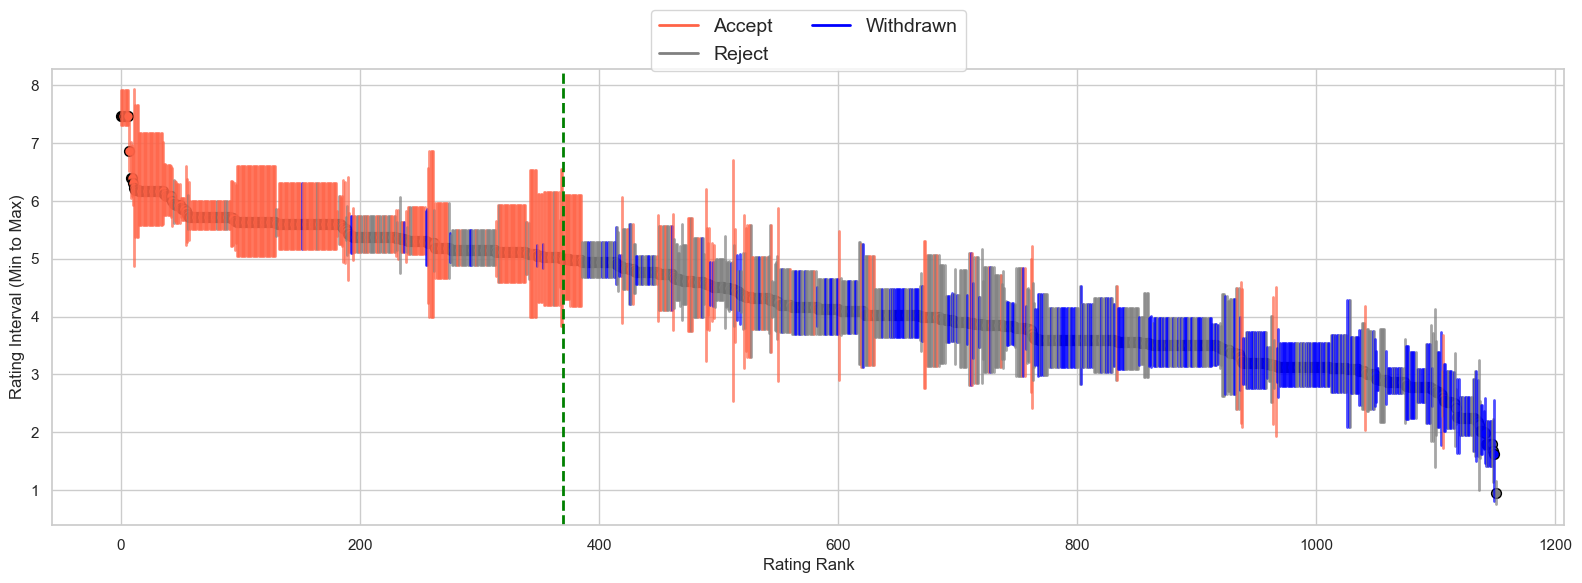

In [62]:
# order ratings by mean
ratings_sample = ratings_sample.sort_values('theta_mean', ascending=False).reset_index(drop=True)

# Set the style
sns.set(style="whitegrid")
# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Accept': '#FF6347',  # Tomato
    'Reject': '#808080',          # Gray
    'Withdrawn': '#0000FF'  # Blue
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], [row['theta_lower50'], row['theta_upper50']], color=color, alpha=0.7, lw=2)
    ax.scatter(idx, row['theta_mean'], color=color, edgecolor='black', s=50, label=row['decision'] if row['decision'] not in ax.get_legend_handles_labels()[1] else "")

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Accept'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()

In [63]:
ratings.decision.value_counts()

decision
Reject                4939
Accept (Poster)       3111
Withdrawn             2870
Accept (Spotlight)     379
Accept (Oral)          213
Name: count, dtype: int64

## Generate Subjectivity Intervals

In [8]:
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from fit_subjectivity_model import fit_subjectivity_model


In [ ]:
adjusted_scores = fit_subjectivity_model(df)

/Users/akgoldbe/opt/anaconda3/envs/analysis/lib/python3.11/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) May 11 12:56:02 PM: Your problem has 59 variables, 0 constraints, and 0 parameters.
(CVXPY) May 11 01:00:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 01:00:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 01:00:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 01:00:45 PM: Compiling problem (target solver=OSQP).
(CVXPY) May 11 01:00:45 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [ ]:
df['adjusted_score'] = adjusted_scores
ratings = df.groupby('paper_id').agg({'adjusted_score': ['mean'], 'decision': 'max', 'rating': 'mean'}).reset_index()
ratings.columns = ['paper_id', 'adjusted_score', 'decision', 'rating']
ratings['subjectivity_interval'] = [sorted(I) for I in zip(ratings['adjusted_score'], ratings['rating'])]

In [ ]:
# subsample ratings by 10% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.10, random_state=42)
).reset_index(drop=True)

# order ratings by mean
ratings_sample = ratings_sample.sort_values('rating', ascending=False).reset_index(drop=True)
ratings_sample = ratings_sample[ratings_sample['decision'] != 'Reject']

ratings_sample['decision'] = ratings_sample['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})

# Set the style
sns.set(style="whitegrid")
# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Spotlight/Oral': '#FF6347',  # Tomato
    'Poster': '#808080',          # Gray
    'Withdrawn': '#0000FF'  # Blue
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], row['subjectivity_interval'], color=color, alpha=0.7, lw=2)

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Spotlight/Oral'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Poster/Spotlight Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()

In [ ]:
ratings.to_csv('iclr2025_subjectivity_intervals.csv')